# EECS 498-007/598-005 Assignment 5-2: Two-Stage Object Detector - Faster R-CNN

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Firstname Lastname, #UMID

# Faster R-CNN: A Classic Two-Stage Anchor-Based Object Detector

In this exercise you will implement a **two-stage** object detector, based on [Faster R-CNN](https://arxiv.org/pdf/1506.01497.pdf), which consists of two modules - Region Proposal Networks (RPN) and Fast R-CNN.
Like one-stage detector in the first part of our assignment,
we will train it to detect a set of object classes and evaluate the detection accuracy using the classic metric mean Average Precision ([mAP](https://github.com/Cartucho/mAP)).

# Getting Started

## Setup Code
Before getting started, we need to run some boilerplate code to set up our environment, same as previous assignments. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
# from google.colab import drive

# drive.mount("/content/drive")

Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the following cell should print the filenames from the assignment:

```
["common.py", "one_stage_detector.ipynb", "two_stage_detector_faster_rcnn.ipynb", "eecs598", "one_stage_detector.py", "two_stage_detector.py", "a4_helper.py"]
```

In [3]:
import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2022WI folder and put all the files under A4 folder, then "2022WI/A4"
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = None
# GOOGLE_DRIVE_PATH = os.path.join("drive", "My Drive", GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_PATH = '.'
print(os.listdir(GOOGLE_DRIVE_PATH))


# Add to sys so we can import .py files.
sys.path.append(GOOGLE_DRIVE_PATH)

['.gitignore', 'a4_helper.py', 'common.py', 'eecs598', 'FCOS.pdf', 'fcos_detector.pt', 'fcos_detector2.pt', 'main.ipynb', 'mAP', 'notes', 'old', 'one_stage_detector.ipynb', 'one_stage_detector.py', 'original', 'output', 'rcnn_detector.pt', 'two_stage_detector.ipynb', 'two_stage_detector.py', 'voc07_train.json', 'voc07_val.json', 'VOCdevkit', '__pycache__']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from common.py!
Hello from two_stage_detector.py!
Hello from a4_helper.py!
```

as well as the last edit time for the file `two_stage_detector.py`.

In [4]:
import os
import time

# os.environ["TZ"] = "US/Eastern"
# time.tzset()

from common import hello_common
from two_stage_detector import hello_two_stage_detector
from a4_helper import hello_helper


hello_common()
hello_two_stage_detector()
hello_helper()

two_stage_detector_path = os.path.join(GOOGLE_DRIVE_PATH, "two_stage_detector.py")
two_stage_detector_edit_time = time.ctime(
    os.path.getmtime(two_stage_detector_path)
)
print("two_stage_detector.py last edited on %s" % two_stage_detector_edit_time)

Hello from common.py!
Hello from two_stage_detector.py!
Hello from a4_helper.py!
two_stage_detector.py last edited on Fri Apr 26 22:40:04 2024


Load several useful packages that are used in this notebook:

In [5]:
import os
import time

import matplotlib.pyplot as plt
import torch
import torchvision

%matplotlib inline

from a4_helper import *
from eecs598 import reset_seed
from eecs598.grad import rel_error

# for plotting
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# To download the dataset
!pip install wget

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

'rm' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
fatal: destination path 'mAP' already exists and is not an empty directory.
'rm' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [6]:
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    DEVICE = torch.device("cpu")

Good to go!


## Load PASCAL VOC 2007 data
As in the previous notebook, we will use PASCAL VOC 2007 dataset to train our model. The following two cells are exactly same as those in `one_stage_detector.ipynb`:

In [7]:
import multiprocessing

# Set a few constants related to data loading.
NUM_CLASSES = 20
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224)
# NUM_WORKERS = multiprocessing.cpu_count()
NUM_WORKERS = 0

In [8]:
from a4_helper import VOC2007DetectionTiny

# NOTE: Set `download=True` for the first time when you set up Google Drive folder.
# Turn it back to `False` later for faster execution in the future.
# If this hangs, download and place data in your drive manually as shown in `one_stage_detector.ipynb`.
train_dataset = VOC2007DetectionTiny(
    GOOGLE_DRIVE_PATH, "train", image_size=IMAGE_SHAPE[0],
    download=False  # True (for the first time)
)
val_dataset = VOC2007DetectionTiny(GOOGLE_DRIVE_PATH, "val", image_size=IMAGE_SHAPE[0])

print(f"Dataset sizes: train ({len(train_dataset)}), val ({len(val_dataset)})")

Dataset sizes: train (325), val (82)


Now we wrap these dataset objects with PyTorch dataloaders, similar to `one_stage_detector.ipynb`. The format of output batches will also be same as what you have seen before:

In [9]:
# `pin_memory` speeds up CPU-GPU batch transfer, `num_workers=NUM_WORKERS` loads data
# on the main CPU process, suitable for Colab.
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Use batch_size = 1 during inference - during inference we do not center crop
# the image to detect all objects, hence they may be of different size. It is
# easier and less redundant to use batch_size=1 rather than zero-padding images.
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

train_loader_iter = iter(train_loader)
# image_paths, images, gt_boxes = train_loader_iter.next()
image_paths, images, gt_boxes = next(train_loader_iter)

print(f"image paths           : {image_paths}")
print(f"image batch has shape : {images.shape}")
print(f"gt_boxes has shape    : {gt_boxes.shape}")

print(f"Five boxes per image  :")
print(gt_boxes[:, :5, :])

image paths           : ['.\\VOCdevkit/VOC2007/JPEGImages/Image_20191007035203302.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191007034613453.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191006232617225.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191007034702101.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191006232314183.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191007040228951.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191007034926662.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191007035413994.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191007034900151.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191007022421255.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191007022352672.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191007022230360.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191006233003198.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191007022535514.jpg', '.\\VOCdevkit/VOC2007/JPEGImages/Image_20191007022239534.jpg', '.\\VOCdevkit/VOC2007/JPEGImag

## Visualize PASCAL VOC 2007

We will visualize a few images and their GT boxes, just to make sure that everything is loaded properly. You would have already seen these visualizations (and the code snippet below) in `one_stage_detector.ipynb`.

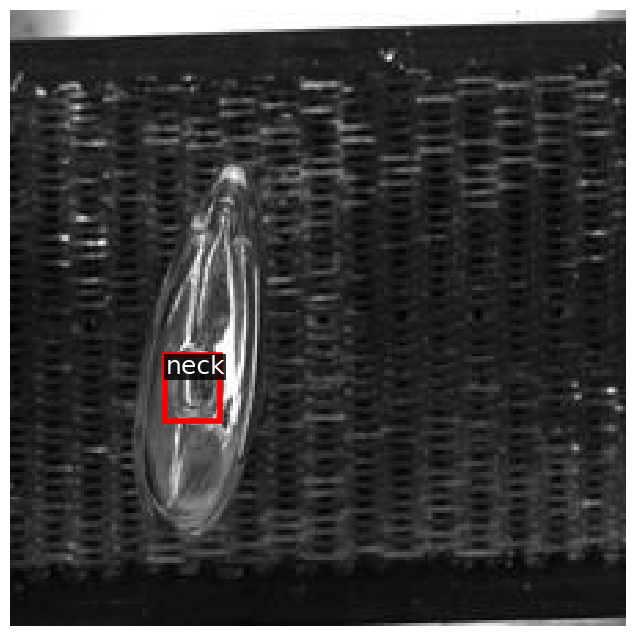

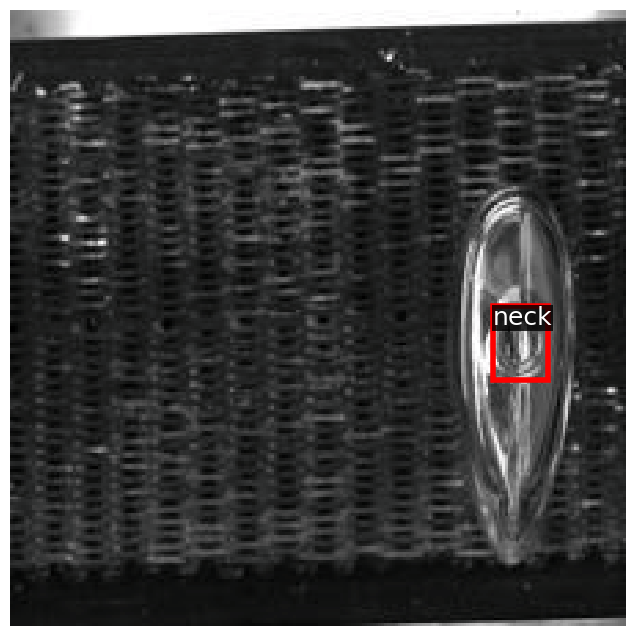

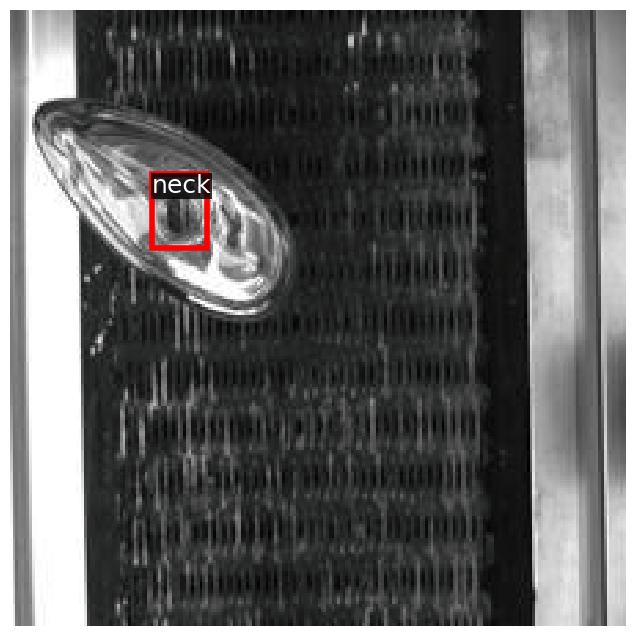

In [10]:
from torchvision import transforms
from eecs598.utils import detection_visualizer

inverse_norm = transforms.Compose(
    [
        transforms.Normalize(mean=[0., 0., 0.], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    ]
)

for idx, (_, image, gt_boxes) in enumerate(train_dataset):
    if idx > 2:
        break

    image = inverse_norm(image)
    is_valid = gt_boxes[:, 4] >= 0
    detection_visualizer(image, val_dataset.idx_to_class, gt_boxes[is_valid])

## Backbone with Feature Pyramid Networks (FPN)

Faster R-CNN uses a convolutional backbone with FPN in the exact same way as you implemented in FCOS. So you can directly re-use it for this part of the assignment.

**NOTE:** Typical state-of-the-art detectors based o nFaster R-CNN use four multi-scale features from different FPN levels — `(p2, p3, p4, p5)` with strides `(4, 8, 16, 32)`.
Due to computational limits of Google Colab, we will instead simply use `(p3, p4, p5)` features like FCOS.
In all your implementations for this part, you may assume that you will receive features from these three FPN levels (and may hard-code these names as Python strings). Your code will not be tested with `p2` FPN features and you will not lose points.

In [11]:
import torch
from common import DetectorBackboneWithFPN
from two_stage_detector import RPNPredictionNetwork


backbone = DetectorBackboneWithFPN(out_channels=64)

# Pass a batch of dummy images (random tensors) in NCHW format and observe the output.
dummy_images = torch.randn(2, 3, 224, 224)

# Collect dummy output.
dummy_fpn_feats = backbone(dummy_images)

d:\Anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
d:\Anaconda3\envs\cv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=RegNet_X_400MF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_X_400MF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])


## Faster R-CNN first stage: Region Proposal Network (RPN)

We will now implement the first-stage of Faster R-CNN. It comprises a **Region Proposal Network (RPN)** that learns to predict general _object proposals_, which will then be used by the second stage to make final predictions.

**RPN prediction:** An input image is passed through the backbone and we obtain its FPN feature maps `(p3, p4, p5)`.
The RPN predicts multiple values at _every location on FPN features_. Faster R-CNN is _anchor-based_ — the model assumes that every location has multiple pre-defined boxes (called "anchors") and it predicts two measures per anchor, per FPN location:

1. **Objectness:** The likelihood of having _any_ object inside the anchor. This is similar to classification head in FCOS, except that this is _class-agnostic_: it only performs binary foreground/background classification.
2. **Box regression deltas:** 4-D "deltas" that _transform_ an anchor at that location to a ground-truth box.

![pred_scores2](https://miro.medium.com/max/918/1*wB3ctS9WGNmw6pP_kjLjgg.png)

**SIDE NOTE:** We will use the more common practice of predicting `k` logits and use a logistic regressor instead of `2k` scores (and 2-way softmax) as shown in Figure. This slightly reduces the number of trainable parameters.

This RPN is conceptually quite similar to a one-stage detector like FCOS.
The main differences with what you implemented in FCOS are: (1) RPN is anchor-based, and make predictions for multiple anchor boxes instead of location "points", (2) it performs class-agnostic object classification, and (3) it excludes centerness regression, which was inntroduced in FCOS itself, years after Faster R-CNN was published.

Like we saw in FCOS, each anchor will be matched with a GT box for supervision — we will get to it shortly.
For now, let's assume there are some `A` anchor boxes at every FPN location, and implement an RPN module.
Structurally, this module is similar to FCOS prediction network.
Now follow the instructions in `RPNPredictionNetwork` of `two_stage_detector.py` and implement layers to predict objectness and box regression deltas.
Execute the following cell to test your implementation:

In [12]:
from two_stage_detector import RPNPredictionNetwork

rpn_pred_net = RPNPredictionNetwork(
    in_channels=64, stem_channels=[64], num_anchors=3
)

# Pass the dummy FPN feats to RPN prediction network and view its output shapes.
dummy_rpn_obj, dummy_rpn_box = rpn_pred_net(dummy_fpn_feats)

# Few expected outputs:
# Shape of p4 RPN objectness: torch.Size([2, 196, 3])
# Shape of p5 RPN box deltas: torch.Size([2, 49, 12])

print(f"\nFor dummy input images with shape: {dummy_images.shape}")
for level_name in dummy_fpn_feats.keys():
    print(f"Shape of {level_name} FPN features  : {dummy_fpn_feats[level_name].shape}")
    print(f"Shape of {level_name} RPN objectness: {dummy_rpn_obj[level_name].shape}")
    print(f"Shape of {level_name} RPN box deltas: {dummy_rpn_box[level_name].shape}")
    print("")


For dummy input images with shape: torch.Size([2, 3, 224, 224])
Shape of p3 FPN features  : torch.Size([2, 64, 28, 28])
Shape of p3 RPN objectness: torch.Size([2, 2352])
Shape of p3 RPN box deltas: torch.Size([2, 2352, 4])

Shape of p4 FPN features  : torch.Size([2, 64, 14, 14])
Shape of p4 RPN objectness: torch.Size([2, 588])
Shape of p4 RPN box deltas: torch.Size([2, 588, 4])

Shape of p5 FPN features  : torch.Size([2, 64, 7, 7])
Shape of p5 RPN objectness: torch.Size([2, 147])
Shape of p5 RPN box deltas: torch.Size([2, 147, 4])



## Anchor-based Training of RPN

Now that we implemented this RPN head, our goal is to have it predict _high objectness_ and _accurate box deltas_ for anchors that are likely to contain objects.
Similar to first part of our assignment, we need to assign a target GT box to every RPN prediction for training supervision.

**Recall FCOS location matching:** FCOS matched every FPN feature map location with a GT box (or marked them background), based on a heuristic that a location whether that location was _inside_ any GT Box.
On the other hand, Faster R-CNN is anchor-based: instead of _locations_, it makes predictions with reference to some pre-defined _anchor boxes_, and matches each anchor with a single GT box if they have a high enough Intersection-over-Union (IoU).

In the next few cells, we will perform the following steps, which are procedurally very similar to what you have already done with FCOS:

1. **Anchor generation:** Generate a set of anchors for every location in FPN feature map.
2. **Anchor to GT matching:** Match these anchors with GT boxes based on their IoU-overlap.
3. **Format of box deltas:** Implement the tranformation functions to obtain _box deltas_ from GT boxes (model training supervision) and apply deltas to anchors (final proposal boxes for second stage).

Let's approach these steps, one at a time.

### Anchor Generation

Recall that you already implemented a function to get the absolute image co-ordinates of FPN feature map locations, for FCOS — in `get_fpn_location_coords` of `common.py`.
First we need to form multiple anchor boxes centered at these locations.
RPN defines square anchor boxes of size `scale * stride` at every location, where `stride` is the FPN level stride, and `scale` is a hyperparameter.
For example, anchor boxes for P5 level (`stride = 32`), with `scale = 2` will be boxes of `(64 x 64)` pixels.
RPN also considers anchors of different aspect ratios, apart from square anchor boxes —
follow the instructions in `generate_fpn_anchors` of `two_stage_detector.py` to implement creation of multiple anchor boxes per location.

Execute the next cell to verify your implementation:

In [13]:
from common import get_fpn_location_coords
from two_stage_detector import generate_fpn_anchors


# Sanity check: Get 2x2 location co-ordinates of p5 (original shape is 7x7).
locations = get_fpn_location_coords(
    shape_per_fpn_level={"p5": (2, 64, 2, 2)}, strides_per_fpn_level={"p5": 32}
)

print("P5 locations:\n", locations["p5"])

# Generate anchors for these locations.
anchors = generate_fpn_anchors(
    locations_per_fpn_level=locations,
    strides_per_fpn_level={"p5": 32},
    stride_scale=2,
    aspect_ratios=[0.5, 1.0, 2.0],
)

print("P5 anchors with different aspect ratios:")
print("P5 1:2 anchors:\n", anchors["p5"][0::3, :], "\n")
# Expected (any ordering is fine):
# [-29.2548,  -6.6274,  61.2548,  38.6274]
# [-29.2548,  25.3726,  61.2548,  70.6274]
# [  2.7452,  -6.6274,  93.2548,  38.6274]
# [  2.7452,  25.3726,  93.2548,  70.6274]

print("P5 1:1 anchors:\n", anchors["p5"][1::3, :], "\n")
# Expected (any ordering is fine):
# [-16., -16.,  48.,  48.]
# [-16.,  16.,  48.,  80.]
# [ 16., -16.,  80.,  48.]
# [ 16.,  16.,  80.,  80.]

print("P5 2:1 anchors:\n", anchors["p5"][2::3, :], "\n")
# Similar to 1:2 anchors, but with flipped co-ordinates

P5 locations:
 tensor([[16., 16.],
        [16., 48.],
        [48., 16.],
        [48., 48.]])
P5 anchors with different aspect ratios:
P5 1:2 anchors:
 tensor([[-29.2548,  -6.6274,  61.2548,  38.6274],
        [-29.2548,  25.3726,  61.2548,  70.6274],
        [  2.7452,  -6.6274,  93.2548,  38.6274],
        [  2.7452,  25.3726,  93.2548,  70.6274]]) 

P5 1:1 anchors:
 tensor([[-16., -16.,  48.,  48.],
        [-16.,  16.,  48.,  80.],
        [ 16., -16.,  80.,  48.],
        [ 16.,  16.,  80.,  80.]]) 

P5 2:1 anchors:
 tensor([[ -6.6274, -29.2548,  38.6274,  61.2548],
        [ -6.6274,   2.7452,  38.6274,  93.2548],
        [ 25.3726, -29.2548,  70.6274,  61.2548],
        [ 25.3726,   2.7452,  70.6274,  93.2548]]) 



### Matching anchor boxes with GT boxes

Similar to FCOS, we will now match these generated anchors with GT boxes. Faster R-CNN matches some `N` anchor boxes with `M` GT boxes by applying a simple rule:

> Anchor box $N_i$ is matched with box $M_i$ if it has an IoU overlap higher than 0.6 with that box. For multiple such GT boxes, the anchor is assigned with the GT box that has the highest IoU. Note that a single ground-truth box may assign positive labels to multiple anchors.

**NOTE:** _Faster R-CNN uses 0.7 default threshold_ as mentioned in the lecture slides. We use a lower threeshold to increase the number of positive matches for sampling — this helps in speeding up training in a resource constrained setting like Google Colab.

Anchor boxes with `IoU < 0.3` with ALL GT boxes is assigned background GT box `(-1, -1, -1, -1, -1)`. All other anchors with IoU between `(0.3, 0.6)` are considered "neutral" and ignored during training. This matching differs from FCOS, which assigns ALL anchors to either object or background — the "neutral" Faster R-CNN anchors cause wasted computation, and removing this redundancy would overly complicate our implementation.

We have implemented this matching procedure for you — see `rcnn_match_anchors_to_gt` of `two_stage_detector.py`.
Read its documentation to understand its input/output format, it is slightly different than `fcos_match_locations_to_gt`.
It serves the same purpose as location matching in FCOS — to define GT targets for model predictions during training.

This function internally requires IoU computation between all anchors and GT boxes — which you have to implement.
Follow the instructions in `two_stage_detector.py` to implement IoU computation, and execute the next cell for a sanity check — you should observe an error of `1e-7` or less

In [14]:
import torch
from two_stage_detector import iou


boxes1 = torch.Tensor([[10, 10, 90, 90], [20, 20, 40, 40], [60, 60, 80, 80]])
boxes2 = torch.Tensor([[10, 10, 90, 90], [60, 60, 80, 80], [30, 30, 70, 70]])

expected_iou = torch.Tensor(
    [[1.0, 0.0625, 0.25], [0.0625, 0.0, 0.052631579], [0.0625, 1.0, 0.052631579]]
)
result_iou = iou(boxes1, boxes2)

print("Relative error:", rel_error(expected_iou, result_iou))

Relative error: 0.0


### Visualizing matched GT boxes

Now we apply our anchor matching function and visualize one GT box with a random matched positive anchor box.
You may try different images by indexing `train_dataset` below,
make sure to try different FPN levels as certain images may not get any matched GT boxes due to their size.

In [15]:
import random
from common import get_fpn_location_coords
from two_stage_detector import generate_fpn_anchors, rcnn_match_anchors_to_gt


# Sanity check: Match anchors of p4 level with GT boxes of first image
# in the training dataset.
_, image, gt_boxes = train_dataset[0]

FPN_LEVEL = "p4"
FPN_STRIDE = 16
locations = get_fpn_location_coords(
    shape_per_fpn_level={FPN_LEVEL: (2, 64, 224 // FPN_STRIDE, 224 // FPN_STRIDE)},
    strides_per_fpn_level={FPN_LEVEL: FPN_STRIDE}
)
# Generate anchors for these locations.
anchors = generate_fpn_anchors(
    locations_per_fpn_level=locations,
    strides_per_fpn_level={FPN_LEVEL: FPN_STRIDE},
    stride_scale=8,  # Default value used by Faster R-CNN
    aspect_ratios=[0.5, 1.0, 2.0],
)

matched_gt_boxes = rcnn_match_anchors_to_gt(
    anchors[FPN_LEVEL], gt_boxes, iou_thresholds=(0.3, 0.6)
)

# Flatten anchors and matched boxes:
anchors_p4 = anchors[FPN_LEVEL].view(-1, 4)
matched_boxes_p4 = matched_gt_boxes.view(-1, 5)

# Visualize one selected anchor and its matched GT box.
# NOTE: Run this cell multiple times to see different matched anchors. For car
# image, p3/5 will not work because the GT box was already assigned to p4.
fg_idxs_p4 = (matched_boxes_p4[:, 4] > 0).nonzero()
fg_idx = random.choice(fg_idxs_p4)

# Combine both boxes for visualization:
dummy_vis_boxes = [anchors_p4[fg_idx][0], matched_boxes_p4[fg_idx][0]]

print("Unlabeled red box is positive anchor:")
detection_visualizer(
    inverse_norm(image),
    val_dataset.idx_to_class,
    bbox=dummy_vis_boxes,
)

IndexError: index 0 is out of bounds for dimension 0 with size 0

### GT Targets for box regression

Now we work on the third and final component needed to train our RPN — we define transformation functions for box regression deltas.
Recall in the first part of the assignment, you implemented two such functions for FCOS (quoting from `one_stage_detector.ipynb`):

> 1. `fcos_get_deltas_from_locations`: Accepts locations (centers) and GT boxes, and returns deltas. Required for training supervision.
> 2. `fcos_apply_deltas_to_locations`: Accepts predicted deltas and locations, and returns predicted boxes. Required during inference.

Here you will implement similar transformation functions for R-CNN, albeit with a different transformation logic than FCOS. You will find these transforms in [Lecture 13, slides 68-71](https://web.eecs.umich.edu/~justincj/slides/eecs498/WI2022/598_WI2022_lecture13.pdf), follow these and implement two functions in `two_stage_detector.py`:

1. `rcnn_get_deltas_from_anchors`: Accepts anchor boxes and GT boxes, and returns deltas. Required for training supervision.
2. `rcnn_apply_deltas_to_anchors`: Accepts predicted deltas and anchor boxes, and returns predicted boxes. Required during inference.

Run the following cell to check your implementation.

In [16]:
import torch
from two_stage_detector import rcnn_get_deltas_from_anchors, rcnn_apply_deltas_to_anchors

# Three hard-coded anchor boxes and GT boxes that have a fairly high overlap.
# Add a dummy class ID = 1 indicating foreground
input_anchors = torch.Tensor(
    [[20, 40, 80, 90], [10, 10, 50, 50], [120, 100, 200, 200]]
)
input_boxes = torch.Tensor(
    [[10, 15, 100, 115, 1], [30, 20, 40, 30, 1], [120, 100, 200, 200, 1]]
)

# Here we do a simple sanity check - getting deltas for a particular set of boxes
# and applying them back to anchors should give us the same boxes.
_deltas = rcnn_get_deltas_from_anchors(input_anchors, input_boxes)
output_boxes = rcnn_apply_deltas_to_anchors(_deltas, input_anchors)

print("Rel error in reconstructed boxes:", rel_error(input_boxes[:, :4], output_boxes))

# Another check: deltas for GT class label = -1 should be -1e8
background_box = torch.Tensor([[-1, -1, -1, -1, -1]])
input_anchor = torch.Tensor([[100, 100, 200, 200]])

_deltas = rcnn_get_deltas_from_anchors(input_anchor, background_box)
output_box = rcnn_apply_deltas_to_anchors(_deltas, input_anchor)

print("Background deltas should be all -1e8  :", _deltas)
print("Output box should be -1e8 or lower    :", output_box)

Rel error in reconstructed boxes: 0.0
Background deltas should be all -1e8  : tensor([[-100000000., -100000000., -100000000., -100000000.]])
Output box should be -1e8 or lower    : tensor([[-1.0000e+10, -1.0000e+10, -1.0000e+10, -1.0000e+10]])


## Loss Functions

With all predictions assigned with GT targets, we will proceed to compute losses for training the RPN.
Recall that you used [Focal Loss](https://arxiv.org/abs/1708.02002) for classification and L1 loss for box regression in FCOS.
Here, you will use L1 loss for box regression, similar to FCOS.

**Objectness classification loss:** Focal Loss was proposed in RetinaNet (2017) to deal with heavy class imbalance caused by "background". Faster R-CNN predates this paper — it dealt with class imbalance by randomly sampling roughly equal amount of foreground-background anchors to train RPN. We have implemented a very simple sampling function for you in `sample_rpn_training` function of `two_stage_detector.py` — you may directly use it while you piece all these components (coming up next).

**Total loss** is the sum of both loss components _per sampled anchor_, averaged by total number of foreground + background anchors.

Execute the next cell to quickly recap their usage — you have already seen these in the first part of this assignment.

In [17]:
import torch
from torch.nn import functional as F


# Sanity check: dummy predictions from model - box regression deltas and
# objectness logits for two anchors.
# shape: (batch_size, HWA, 4 or 1)
dummy_pred_boxreg_deltas = torch.randn(1, 2, 4)
dummy_pred_obj_logits = torch.randn(1, 2, 1)

# Dummy deltas and objectness targets. Let the second box be background.
# Dummy GT boxes (matched with both anchors).
dummy_gt_deltas = torch.randn_like(dummy_pred_boxreg_deltas)
dummy_gt_deltas[:, 1, :] = -1e8

# Background objectness targets should be 0 (not -1), and foreground
# should be 1. Neutral anchors will not occur here due to sampling.
dummy_gt_objectness = torch.Tensor([1, 0])

# Note that loss is not multiplied with 0.25 here:
loss_box = F.l1_loss(
    dummy_pred_boxreg_deltas, dummy_gt_deltas, reduction="none"
)

# No loss for background anchors:
loss_box[dummy_gt_deltas == -1e8] *= 0.0
print("Box regression loss (L1):", loss_box)

# Now calculate objectness loss.
loss_obj = F.binary_cross_entropy_with_logits(
    dummy_pred_obj_logits.view(-1), dummy_gt_objectness, reduction="none"
)
print("Objectness loss (BCE):", loss_obj)

Box regression loss (L1): tensor([[[0.7848, 2.0189, 1.9993, 0.0998],
         [0.0000, 0.0000, 0.0000, 0.0000]]])
Objectness loss (BCE): tensor([0.6720, 0.5935])


## Putting it all together: RPN module

Now you will put together all the things you have implemented into the `RPN` class in `two_stage_detector.py`.
Implement `forward` and `predict_proposals` functions of this module — you have already done most of the heavy lifting, you simply need to call all the functions in a correct way!
Use the previous two cells as a reference to implement loss calculation in `forward()`.

**TIP:** It may help if you draw analogies between the implementation logic in this module vs FCOS (`RPN.predict_proposals()` -> `FCOS.inference()`).

## Overfit small data

In Faster R-CNN, the RPN is trained jointly with the second-stage network.
However, to test our RPN implementation, we will first train just the RPN — this is basically a class-agnostic FCOS without centerness.
We will use the `train_detector` function that we used for training FCOS.
You can read its implementation in `a4_helper.py`. 

The loss should generally do down, however the forward pass here is a bit slower than FCOS.

In [19]:
from torch import nn

from a4_helper import train_detector
from common import DetectorBackboneWithFPN
from two_stage_detector import RPN

reset_seed(0)

# Take equally spaced examples from training dataset to make a subset.
small_dataset = torch.utils.data.Subset(
    train_dataset,
    torch.linspace(0, len(train_dataset) - 1, steps=BATCH_SIZE * 10).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Create a wrapper module to contain backbone + RPN:
class FirstStage(nn.Module):
    def __init__(self, fpn_channels: int):
        super().__init__()
        self.backbone = DetectorBackboneWithFPN(out_channels=fpn_channels)
        self.rpn = RPN(
            fpn_channels=fpn_channels,
            # Simple stem of two layers:
            stem_channels=[fpn_channels, fpn_channels],
            batch_size_per_image=16,
            anchor_stride_scale=8,
            anchor_aspect_ratios=[0.5, 1.0, 2.0],
            anchor_iou_thresholds=(0.3, 0.6),
        )

    def forward(self, images, gt_boxes=None):
        feats_per_fpn_level = self.backbone(images)
        return self.rpn(feats_per_fpn_level, self.backbone.fpn_strides, gt_boxes)


first_stage = FirstStage(fpn_channels=64).to(DEVICE)

train_detector(
    first_stage,
    small_train_loader,
    learning_rate=8e-3,
    max_iters=1000,
    log_period=20,
    device=DEVICE,
)

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
[Iter 0][loss: 133.760][loss_rpn_obj: 133.760][loss_rpn_box: 0.000]
[Iter 20][loss: 0.000][loss_rpn_obj: 0.000][loss_rpn_box: 0.000]
[Iter 40][loss: 0.000][loss_rpn_obj: 0.000][loss_rpn_box: 0.000]
[Iter 60][loss: 0.000][loss_rpn_obj: 0.000][loss_rpn_box: 0.000]
[Iter 80][loss: 0.000][loss_rpn_obj: 0.000][loss_rpn_box: 0.000]


KeyboardInterrupt: 

# Faster R-CNN

We have implemented the first half of Faster R-CNN, i.e., RPN, which is class-agnostic. Here, we briefly describe the second half Fast R-CNN.

Given a set of proposal boxes from RPN (per FPN level, per image),
we warp each region from the correspondng map to a fixed size 7x7 by using [RoI Align](https://arxiv.org/pdf/1703.06870.pdf).
We will use the `roi_align` function from `torchvision`. For usage instructions, see https://pytorch.org/docs/stable/torchvision/ops.html#torchvision.ops.roi_align

For simplicity and computational constraints of Google Colab,
our two-stage detector here differs from a standard Faster R-CNN system in the second stage:
In a full implementation, the second stage of the network would predict a box deltas to further refine RPN proposals.
We omit this for simplicity and keep RPN proposal boxes as final predictions.
Your model will definitely perform better if you add an extra box regression head in second stage.

### Your implementation exercise

Read `FasterRCNN` class documentation and code to understand how everything is pieced together.
By now you have already implemented the core components of a typical object detection system - you have dealt with anchor boxes or locations (FCOS), matched them with GT boxes, supervised model with your matching, and wrote inference utilities like NMS.
Great work!

### Classification Loss: cross entropy

The classification loss for second-stage is a cross entropy loss — you would have seen this in A3, and it is a multi-class extension of binary cross entropy loss used in RPN objectness classification. You may use `torch.nn.functional.cross_entropy` directly — follow instructions in Python script.

Beyond these, the second stage of Faster R-CNN doesn't add anything that is conceptually new — hence your implementation exercise is fairly lightweight.
We have implemented most of this module for you. We left out a few 3-4 line TODO blocks, only because if we wrote them, they would given away the solution for prior exercises (RPN and FCOS).
Moreover, empty code blocks will encourage you to carefully read the remaining portions for making everything work.
Feel free to refer/re-use your own implementation from the first part of the assignment for filling these blocks.

## Overfit small data

After adding your implementation, overfit the model on a small dataset.

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
[Iter 0][loss: 131.113][loss_rpn_obj: 133.658][loss_rpn_box: 0.039][loss_cls: -2.584]


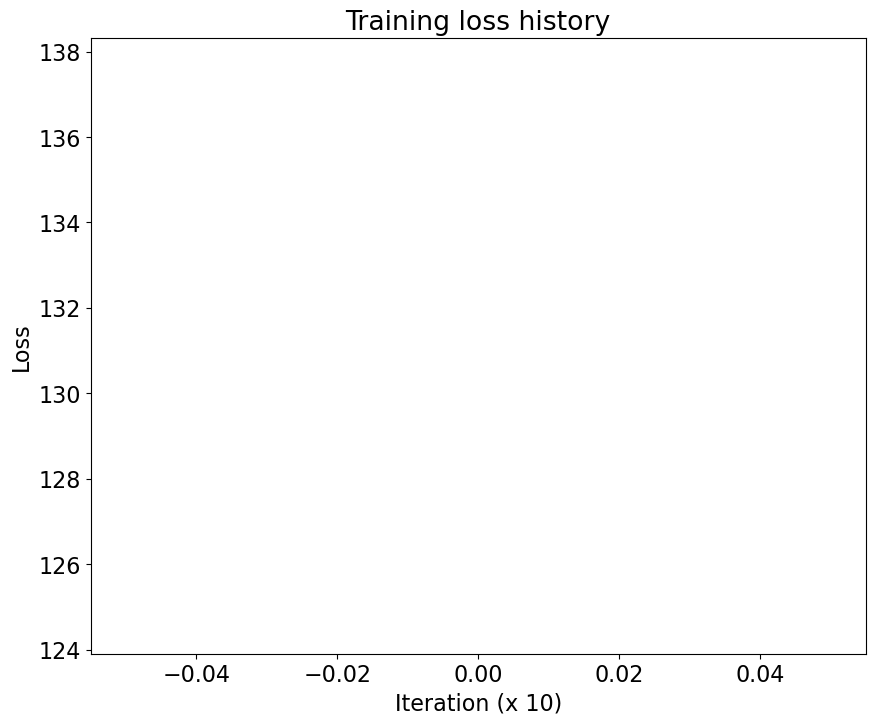

In [19]:
from two_stage_detector import FasterRCNN


# Re-initialize dataset objects for independent debugging.
small_dataset = torch.utils.data.Subset(
    train_dataset,
    torch.linspace(0, len(train_dataset) - 1, steps=BATCH_SIZE * 10).long()
)
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

FPN_CHANNELS = 64
backbone = DetectorBackboneWithFPN(out_channels=FPN_CHANNELS)
rpn = RPN(
    fpn_channels=FPN_CHANNELS,
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=16,
    anchor_stride_scale=8,
    anchor_aspect_ratios=[0.5, 1.0, 2.0],
    anchor_iou_thresholds=(0.3, 0.6),
    pre_nms_topk=400,
    post_nms_topk=80,
)
# fmt: off
faster_rcnn = FasterRCNN(
    backbone, rpn, num_classes=20, roi_size=(7, 7),
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=32,
)
# fmt: on

train_detector(
    faster_rcnn,
    small_train_loader,
    learning_rate=0.01,
    max_iters=1,
    log_period=10,
    device=DEVICE,
)

## Inference

Now, follow the instructions in `FasterRCNN.inference` to implement inference, similar to `FCOS.inference`.

Visualize the output from the trained model on a few images by executing the next cell, the bounding boxes should be somewhat accurate. They would get even better by using a bigger model and training it for longer.

In [25]:
from a4_helper import inference_with_detector


# Change the loader to have (batch size = 1) as required for inference.
small_train_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

inference_with_detector(
    faster_rcnn,
    small_train_loader,
    val_dataset.idx_to_class,
    score_thresh=0.2,
    nms_thresh=0.5,
    device=DEVICE,
    dtype=torch.float32,
)

Total inference time: 17.5s


## Train a net

Now it's time to train the full Faster R-CNN model on a larger subset of the the training data.
We will train for 9000 iterations; this should take about 2-3 hours on a K80 GPU.
Note that real object detection systems typically train for 12-24 hours, distribute training over multiple GPUs, and use much faster GPUs. As such our result will be far from the state of the art, but it should give some reasonable results!

(Optional) If you train the model longer (e.g., 25K+ iterations), you should see a better mAP. But make sure you revert the code back for grading purposes.

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
[Iter 0][loss: 130.906][loss_rpn_obj: 133.617][loss_rpn_box: 0.026][loss_cls: -2.737]


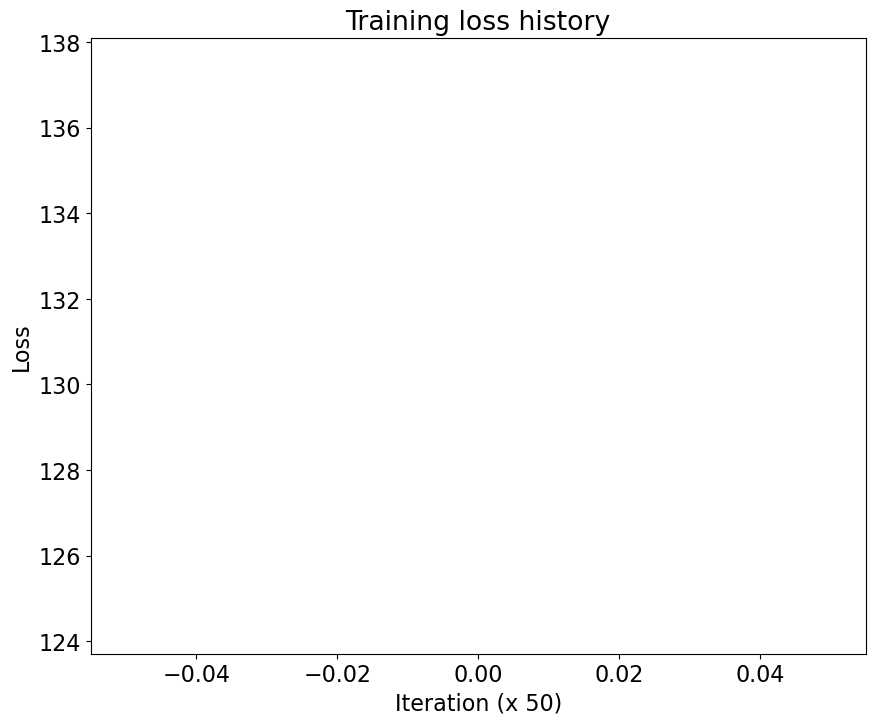

In [21]:
reset_seed(0)

# Slightly larger detector than in above cell.
FPN_CHANNELS = 128
backbone = DetectorBackboneWithFPN(out_channels=FPN_CHANNELS)
rpn = RPN(
    fpn_channels=FPN_CHANNELS,
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=16,
    pre_nms_topk=500,
    post_nms_topk=200  # Other args from previous cell are default args in RPN.
)
# fmt: off
faster_rcnn = FasterRCNN(
    backbone, rpn, num_classes=NUM_CLASSES, roi_size=(7, 7),
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=32,
)
# fmt: on

train_detector(
    faster_rcnn,
    train_loader,
    learning_rate=0.01,
    max_iters=1,
    log_period=50,
    device=DEVICE,
)

# After you've trained your model, save the weights for submission.
weights_path = os.path.join(GOOGLE_DRIVE_PATH, "rcnn_detector.pt")
torch.save(faster_rcnn.state_dict(), weights_path)

### Inference

VIsualize a few outputs from the full trained model. They may be less accurate than FCOS.
This is expected since our Faster R-CNN model is weaker than expected: we used a smaller model, trained for short duration, and did not include box regression in the second stage.

In [26]:
# Add some imports to run this cell independently of above few cells
# (you will need to run first few cells at the top)
from a4_helper import inference_with_detector
from common import DetectorBackboneWithFPN
from two_stage_detector import RPN, FasterRCNN


# Re-initialize so this cell is independent from prior cells.
# Slightly larger detector than in above cell.
FPN_CHANNELS = 128
backbone = DetectorBackboneWithFPN(out_channels=FPN_CHANNELS)
rpn = RPN(fpn_channels=FPN_CHANNELS, stem_channels=[FPN_CHANNELS, FPN_CHANNELS],batch_size_per_image=32)
faster_rcnn = FasterRCNN(
    backbone, rpn, num_classes=NUM_CLASSES, roi_size=(7, 7),
    stem_channels=[FPN_CHANNELS, FPN_CHANNELS],
    batch_size_per_image=32,
)
faster_rcnn.to(device=DEVICE)

weights_path = os.path.join(GOOGLE_DRIVE_PATH, "rcnn_detector.pt")
faster_rcnn.load_state_dict(torch.load(weights_path, map_location="cpu"))

# Prepare a small val daataset for inference:
small_dataset = torch.utils.data.Subset(
    val_dataset,
    torch.linspace(0, len(val_dataset) - 1, steps=20).long()
)
small_val_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

inference_with_detector(
    faster_rcnn,
    small_val_loader,
    val_dataset.idx_to_class,
    score_thresh=0.2,
    nms_thresh=0.5,
    device=DEVICE,
    dtype=torch.float32,
)

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
Total inference time: 17.9s


## Evaluation

Evaluate your Faster R-CNN like FCOS.
(**NOTE:** It is okay if your model does not perform as good as your FCOS implementation, since we didn't train for FCOS.)

In [27]:
inference_with_detector(
    faster_rcnn,
    val_loader,
    val_dataset.idx_to_class,
    score_thresh=0.2,
    nms_thresh=0.5,
    device=DEVICE,
    dtype=torch.float32,
    output_dir="mAP/input",
)
!cd mAP && python main.py

# This script outputs an image containing per-class AP. Display it here:
from IPython.display import Image
Image(filename="./mAP/output/mAP.png")

KeyboardInterrupt: 

# Submit Your Work
After completing both notebooks for this assignment (`one_stage_detector.ipynb` and this notebook, `two_stage_detector.ipynb`), run the following cell to create a `.zip` file for you to download and turn in. 

**Please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell:**

In [ ]:
from eecs598.submit import make_a4_submission

# TODO: Replace these with your actual uniquename and umid
uniquename = None
umid = None
make_a4_submission(GOOGLE_DRIVE_PATH, uniquename, umid)